# 1. Data loading

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RAND_STATE = 0

In [ ]:
# Load the dataset using the load_boston sklearn function:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston
dataset = load_boston()

# Print the dataset description to understand the data we will be working with
print(dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
# Load the data and the target into a single pandas DataFrame
# Hint: You can add the target as a separate column after the data construction
data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['MEDV'] = dataset.target

# Print out the data shape
print('Dimensionality of the dataset:', data.shape, '\n')

# Display the first five elements of the data (the "head")
data.head()

Dimensionality of the dataset: (506, 14) 



,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# 2. Regression analysis

## Preliminary (assumptions) analysis

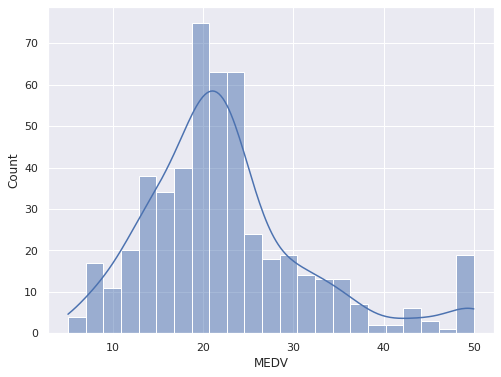

In [ ]:
# Plot the distribution of the target variable MEDV.
# This time we will use the seaborn library to plot our data.
sns.set(rc={'figure.figsize':(8,6)})
sns.histplot(data['MEDV'], kde=True)
plt.show()

# You should see that the values of MEDV are distributed normally with a few outliers.

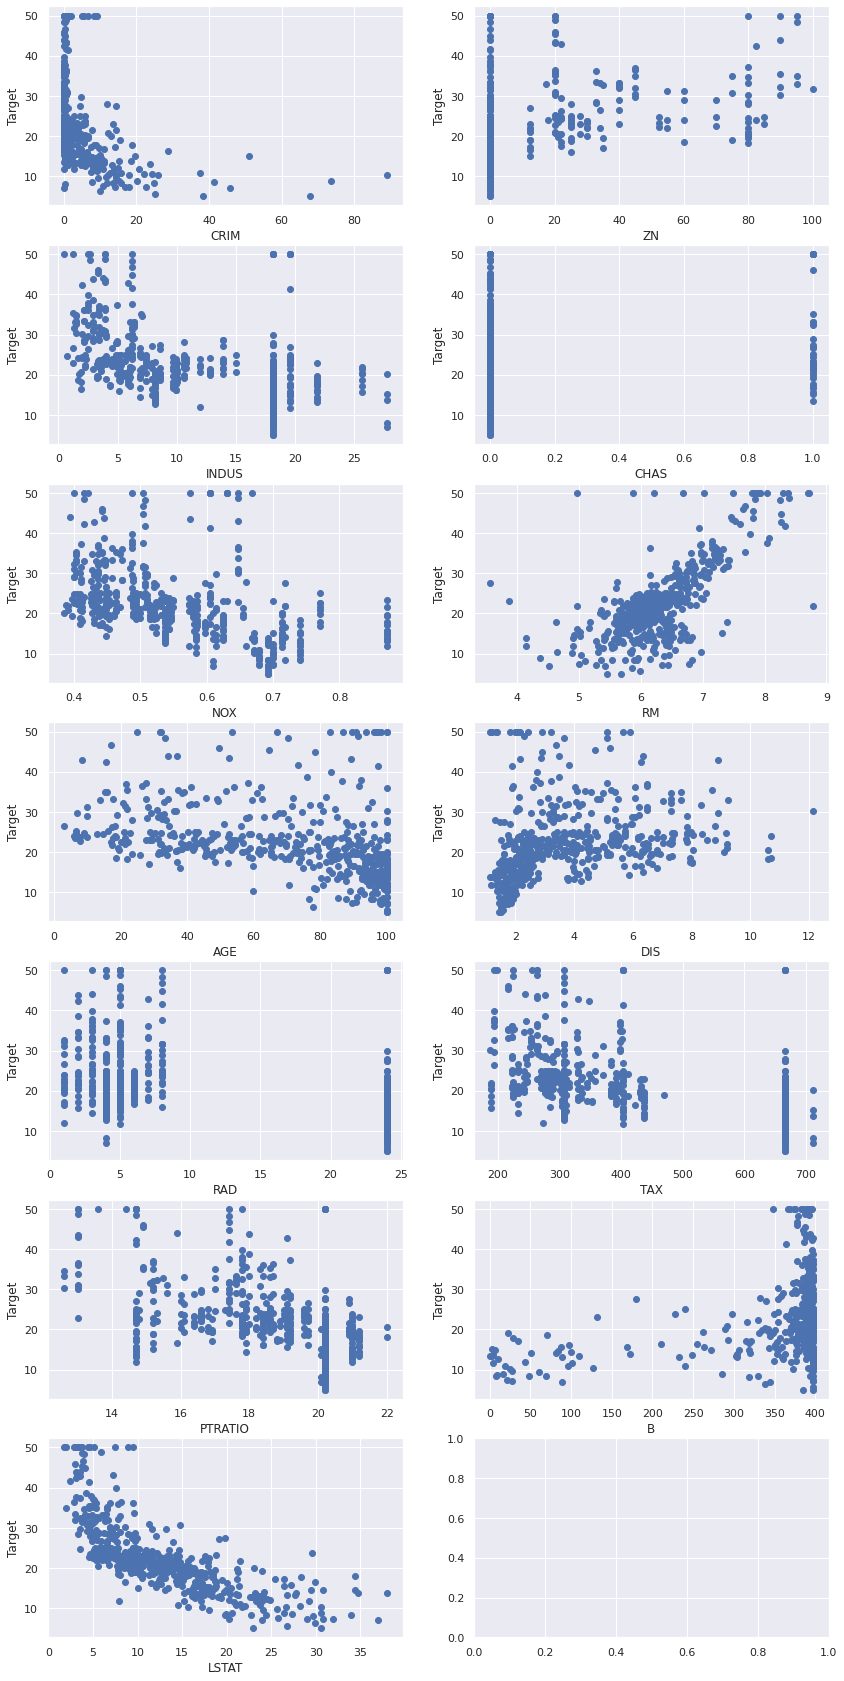

In [ ]:
# As we saw before, there are some requirements that we need to fulfill in order to make best use of linear regression.
# The first one is that the data should display some form a linear relation. We can check this by performing a scatter
# plot of each feature (x) with the target (y).

fig, axs = plt.subplots(7, 2, figsize=(14, 30))
for index, feature in enumerate(dataset.feature_names):
    subplot_idx = int(index / 2)
    if index % 2 == 0:
        axs[subplot_idx, 0].scatter(x=data.loc[:, feature], y=data.loc[:, 'MEDV'])
        axs[subplot_idx, 0].set_xlabel(feature)
        axs[subplot_idx, 0].set_ylabel("Target")
    else:
        axs[subplot_idx, 1].scatter(x=data.loc[:, feature], y=data.loc[:, 'MEDV'])
        axs[subplot_idx, 1].set_xlabel(feature)
        axs[subplot_idx, 1].set_ylabel("Target")

plt.show()

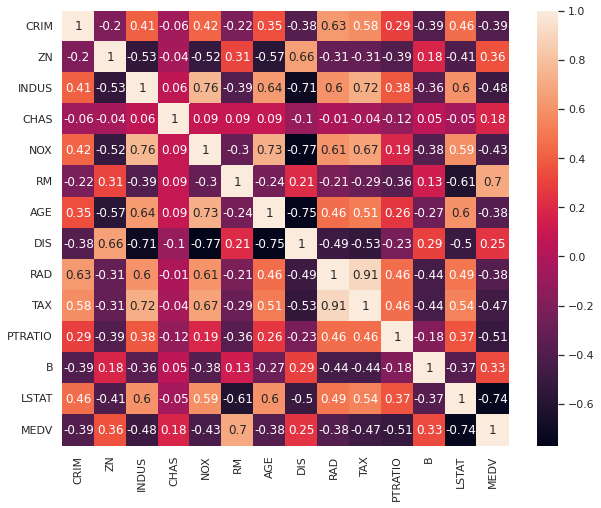

In [ ]:
# Next we need to check if the data are co-linear. In linear regression high co-linearity between the features is a
# problem. We can see how much the data is correlated by looking at a correlation coefficient. Since our features are all
# numerical, we'll use the famous Pearson correlation coefficient, which measures exactly the strength of a linear relationship.

# Create a correlation matrix that measures the linear relationships between the variables. 
# The correlation matrix can be formed by using the corr function from the pandas. 
# Use the heatmap function from the seaborn library to plot the correlation matrix.

correlation_matrix = data.corr().round(2)
annot = True # True to print the values inside the square
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(data=correlation_matrix, annot=annot)
plt.show()

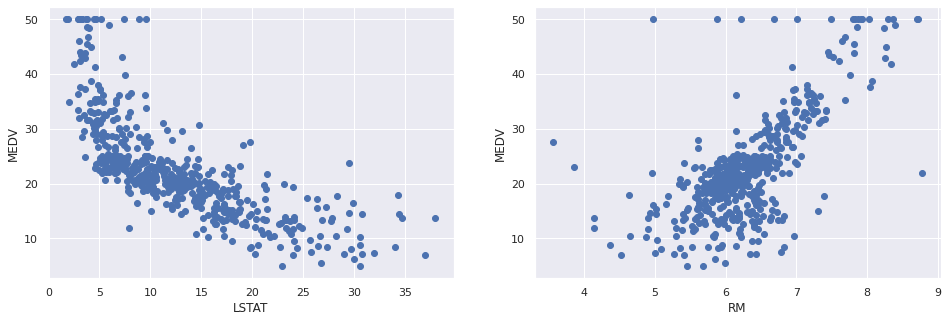

In [ ]:
# From the above analysis, you should select the two features that you think will work best in this regression problem
# Create a list with the chosen features and plot them against the target variable to as a final qualitative validation 
# of your choice

features = ['LSTAT', 'RM']
target = data.loc[:, 'MEDV']

plt.figure(figsize=(16, 5))
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = data[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.xlabel(col)
    plt.ylabel('MEDV')
plt.show()

## Data pre-processing

In [ ]:
# Scale all the values inside the dataframe to set up our regression problem.
# Afterwards separate the values into numpy arrays, creating two different
# training arrays: One with all the features and another one with only
# your two chosen features.

scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

X_all = scaled_data[:, :-1]
X_sm = scaled_data[:, [5, 12]]
y = scaled_data[:, -1]

# Print out the shapes of the newly created variables as verification
print(X_all.shape, X_sm.shape, y.shape)

(506, 13) (506, 2) (506,)


## Linear Regression: Least Squares Estimation

Projection matrix: [ 0.59088219 -0.51731258  0.2371775 ]
LS solution from numpy: [ 0.59088219 -0.51731258  0.2371775 ]


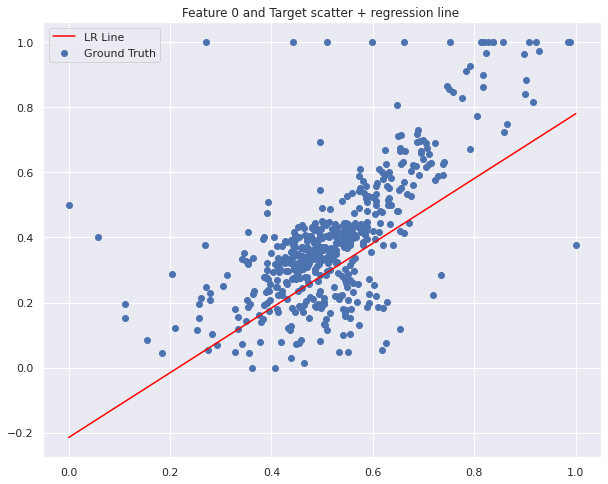

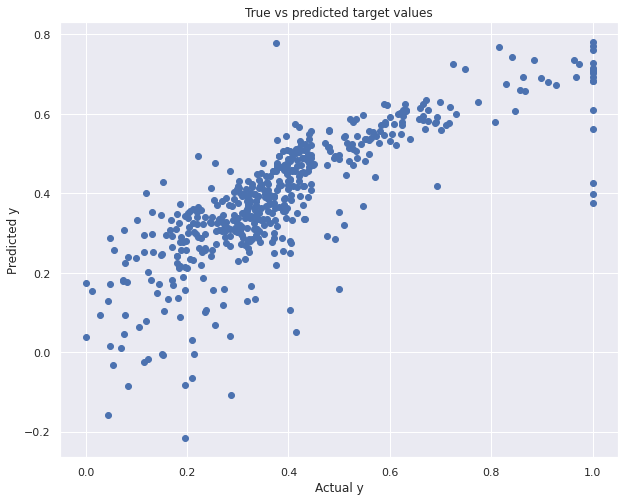

LSE Mean Squared Error: 0.015067885815950354


In [ ]:
# We have seen the least squares solution to  Y = XA + E in the slides (slide 6+)
# Compute the least squares solution using only the chosen features (subset of X)
# Hint: you must add the bias terms explicitly as done below

bias_ones = np.ones((X_sm.shape[0], 1))  # add bias terms
X = np.append(X_sm, bias_ones, axis=1)
pseudo_inverse = np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T)
lse = np.dot(pseudo_inverse, y)
print("Projection matrix:", lse)

# If you wish to verify our solution using numpy
print("LS solution from numpy:", np.linalg.lstsq(X, y, rcond=None)[0])

# Use the least squares solution to fit the data
y_pred = np.matmul(X, lse)

# Plot results
plt.scatter(X[:, 0], y, label="Ground Truth")
plt.plot([min(X[:, 0]), max(X[:, 0])], [min(y_pred), max(y_pred)], color='red', label="LR Line")  # regression line
plt.title('Feature 0 and Target scatter + regression line ')
plt.legend()
plt.show()

plt.scatter(y, y_pred)
plt.title('True vs predicted target values')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()

# Print out the mean squared error
print('LSE Mean Squared Error:', mean_squared_error(y, y_pred))

## Residual analysis

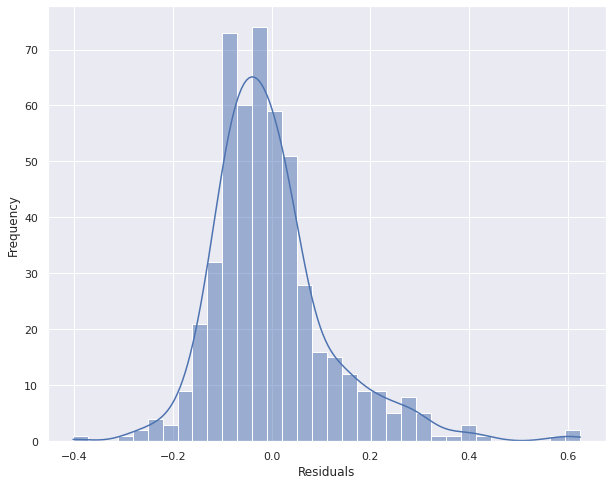

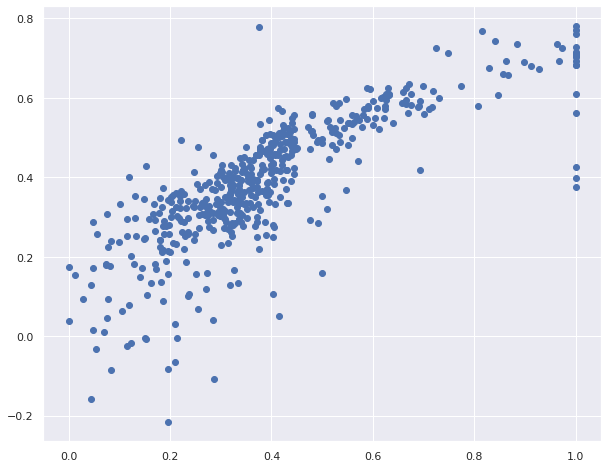

In [ ]:
# The last step in concluding a regression analysis would be checking and understanding the residuals. 
# We expect the residuals to have a normal or "close to normal" distribution.
# Check the distribution of the residuals using a histogram.

residuals = y - y_pred
ax = sns.histplot(residuals, kde=True)
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
plt.show()
plt.scatter(y, y_pred)
plt.show()

## Next time: Linear Regression with Gradient descent and general notes on optimization

# Things to try on your own:
1. Check the R^2 scores of all the solutions we performed above.
2. Try to find another subset of viable features and perform the regression analysis by using that subset.